# MLP 222
* Operate on 16000 GenCode 34 seqs.
* 5-way cross validation. Save best model per CV.
* Report mean accuracy from final re-validation with best 5.
* Use Adam with a learn rate decay schdule.

In [1]:
NC_FILENAME='ncRNA.gc34.processed.fasta'
PC_FILENAME='pcRNA.gc34.processed.fasta'
DATAPATH=""
try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    NC_FILENAME = DATAPATH+NC_FILENAME
    PC_FILENAME = DATAPATH+PC_FILENAME
except:
    IN_COLAB = False
    DATAPATH="" 

EPOCHS=200
SPLITS=5
K=2
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=16
FILENAME='MLP222'
NEURONS=16

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import LayerNormalization
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

## Build model

In [3]:
def compile_model(model):
    adam_default_learn_rate = 0.001
    schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = adam_default_learn_rate*10,
        #decay_steps=100000, decay_rate=0.96, staircase=True)
        decay_steps=10000, decay_rate=0.99, staircase=True)
    # learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    opt = tf.keras.optimizers.Adam(learning_rate=schedule)
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    model.compile(loss=bc, optimizer=opt, metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model(maxlen):
    act="elu"
    #embed_layer  = keras.layers.Embedding(
    #    VOCABULARY_SIZE,EMBED_DIMEN,input_length=maxlen);
    dense1_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    dense2_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt)
    dense3_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt)
    dense4_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt)
    output_layer = keras.layers.Dense(1,  activation="sigmoid",dtype=dt)
    mlp = keras.models.Sequential()
    #mlp.add(embed_layer)
    mlp.add(dense1_layer)
    mlp.add(dense2_layer)
    mlp.add(dense3_layer)
    mlp.add(dense4_layer)
    mlp.add(output_layer)
    mlpc = compile_model(mlp)
    return mlpc

## Load and partition sequences

In [4]:
# Assume file was preprocessed to contain one line per seq.
# Prefer Pandas dataframe but df does not support append.
# For conversion to tensor, must avoid python lists.
def load_fasta(filename,label):
    DEFLINE='>'
    labels=[]
    seqs=[]
    lens=[]
    nums=[]
    num=0
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE:
                seq=line.rstrip()
                num += 1   # first seqnum is 1
                seqlen=len(seq)
                nums.append(num)
                labels.append(label)
                seqs.append(seq)
                lens.append(seqlen)
    df1=pd.DataFrame(nums,columns=['seqnum'])
    df2=pd.DataFrame(labels,columns=['class'])
    df3=pd.DataFrame(seqs,columns=['sequence'])
    df4=pd.DataFrame(lens,columns=['seqlen'])
    df=pd.concat((df1,df2,df3,df4),axis=1)
    return df

def separate_X_and_y(data):
    y=   data[['class']].copy()
    X=   data.drop(columns=['class','seqnum','seqlen'])
    return (X,y)



## Make K-mers

In [5]:
def make_kmer_table(K):
    npad='N'*K
    shorter_kmers=['']
    for i in range(K):
        longer_kmers=[]
        for mer in shorter_kmers:
            longer_kmers.append(mer+'A')
            longer_kmers.append(mer+'C')
            longer_kmers.append(mer+'G')
            longer_kmers.append(mer+'T')
        shorter_kmers = longer_kmers
    all_kmers = shorter_kmers
    kmer_dict = {}
    kmer_dict[npad]=0
    value=1
    for mer in all_kmers:
        kmer_dict[mer]=value
        value += 1
    return kmer_dict

KMER_TABLE=make_kmer_table(K)

def strings_to_vectors(data,uniform_len):
    all_seqs=[]
    for seq in data['sequence']:
        i=0
        seqlen=len(seq)
        kmers=[]
        while i < seqlen-K+1 -1:  # stop at minus one for spaced seed
            #kmer=seq[i:i+2]+seq[i+3:i+5]    # SPACED SEED 2/1/2 for K=4
            kmer=seq[i:i+K]  
            i += 1
            value=KMER_TABLE[kmer]
            kmers.append(value)
        pad_val=0
        while i < uniform_len:
            kmers.append(pad_val)
            i += 1
        all_seqs.append(kmers)
    pd2d=pd.DataFrame(all_seqs)
    return pd2d   # return 2D dataframe, uniform dimensions

In [6]:
def make_kmers(MAXLEN,train_set):
    (X_train_all,y_train_all)=separate_X_and_y(train_set)
    X_train_kmers=strings_to_vectors(X_train_all,MAXLEN)
    # From pandas dataframe to numpy to list to numpy
    num_seqs=len(X_train_kmers)
    tmp_seqs=[]
    for i in range(num_seqs):
        kmer_sequence=X_train_kmers.iloc[i]
        tmp_seqs.append(kmer_sequence)
    X_train_kmers=np.array(tmp_seqs)
    tmp_seqs=None
    labels=y_train_all.to_numpy()
    return (X_train_kmers,labels)

In [7]:
def make_frequencies(Xin):
    Xout=[]
    VOCABULARY_SIZE= 4**K + 1  # plus one for 'NNN'
    for seq in Xin:
        freqs =[0] * VOCABULARY_SIZE
        total = 0
        for kmerval in seq:
            freqs[kmerval] += 1
            total += 1
        for c in range(VOCABULARY_SIZE):
            freqs[c] = freqs[c]/total
        Xout.append(freqs)
    Xnum = np.asarray(Xout)
    return (Xnum)
def make_slice(data_set,min_len,max_len):
    slice = data_set.query('seqlen <= '+str(max_len)+' & seqlen>= '+str(min_len))
    return slice

## Cross validation

In [8]:
def do_cross_validation(X,y,given_model):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        fold += 1
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]        
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=DATAPATH+FILENAME+".cv."+str(fold)+".best"
        mycallbacks = [keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')]   
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  
    print()
    print("%d-way Cross Validation mean %.2f%% (+/- %.2f%%)" % (fold, np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

In [9]:
MINLEN=200
MAXLEN=1000
print("Load data from files.")
nc_seq=load_fasta(NC_FILENAME,0)
pc_seq=load_fasta(PC_FILENAME,1)
train_set=pd.concat((nc_seq,pc_seq),axis=0)
nc_seq=None
pc_seq=None
print("Ready: train_set")
#train_set
print ("Compile the model")
model=build_model(MAXLEN)
print ("Summarize the model")
print(model.summary())  # Print this only once
model.save(DATAPATH+FILENAME+'.model')
print ("Data prep")
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y
print ("Data reshape")
(X_train,y_train)=make_kmers(MAXLEN,subset)
X_train=make_frequencies(X_train)

Load data from files.
Ready: train_set
Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                288       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________
None
Instructions fo

Cross valiation
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5416 - accuracy: 0.7276 - val_loss: 0.5226 - val_accuracy: 0.7542
Epoch 2/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5178 - accuracy: 0.7505 - val_loss: 0.5182 - val_accuracy: 0.7529
Epoch 3/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5083 - accuracy: 0.7589 - val_loss: 0.4849 - val_accuracy: 0.7616
Epoch 4/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5063 - accuracy: 0.7582 - val_loss: 0.5021 - val_accuracy: 0.7542
Epoch 5/200
453/453 [==============================] - 2s 3ms/step - loss: 0.5033 - accuracy: 0.7609 - val_loss: 0.4766 - val_accuracy: 0.7796
Epoch 6/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5021 - accuracy: 0.7594 - val_loss: 0.4795 - val_accuracy: 0.7790
Epoch 7/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5001 - accuracy: 0.761

453/453 [==============================] - 2s 4ms/step - loss: 0.4538 - accuracy: 0.7879 - val_loss: 0.4389 - val_accuracy: 0.7976
Epoch 50/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4519 - accuracy: 0.7888 - val_loss: 0.4633 - val_accuracy: 0.7840
Epoch 51/200
453/453 [==============================] - 2s 4ms/step - loss: 0.4542 - accuracy: 0.7893 - val_loss: 0.4461 - val_accuracy: 0.7933
Epoch 52/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4552 - accuracy: 0.7876 - val_loss: 0.4404 - val_accuracy: 0.7970
Epoch 53/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4509 - accuracy: 0.7894 - val_loss: 0.4575 - val_accuracy: 0.7883
Epoch 54/200
453/453 [==============================] - 2s 5ms/step - loss: 0.4523 - accuracy: 0.7903 - val_loss: 0.4423 - val_accuracy: 0.7927
Epoch 55/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4541 - accuracy: 0.7869 - val_loss: 0.4464 - val_accuracy: 0.7921
Epoch

Epoch 104/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4393 - accuracy: 0.7960 - val_loss: 0.4379 - val_accuracy: 0.7945
Epoch 105/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4392 - accuracy: 0.7971 - val_loss: 0.4409 - val_accuracy: 0.7871
Epoch 106/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4395 - accuracy: 0.7969 - val_loss: 0.4451 - val_accuracy: 0.7921
Epoch 107/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4359 - accuracy: 0.8011 - val_loss: 0.4351 - val_accuracy: 0.7995
Epoch 108/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4376 - accuracy: 0.7976 - val_loss: 0.4292 - val_accuracy: 0.7958
Epoch 109/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4400 - accuracy: 0.7970 - val_loss: 0.4420 - val_accuracy: 0.7908
Epoch 110/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4370 - accuracy: 0.7992 - val_loss: 0.4484 - val_ac

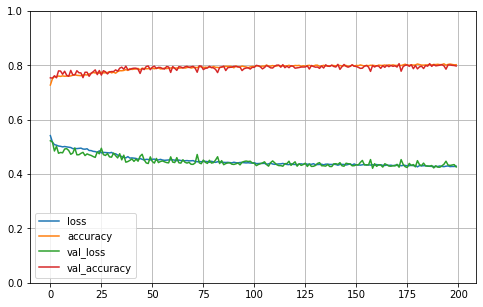

accuracy: 80.63%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5433 - accuracy: 0.7306 - val_loss: 0.5261 - val_accuracy: 0.7405
Epoch 2/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5156 - accuracy: 0.7511 - val_loss: 0.5170 - val_accuracy: 0.7523
Epoch 3/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5132 - accuracy: 0.7500 - val_loss: 0.5038 - val_accuracy: 0.7697
Epoch 4/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5065 - accuracy: 0.7569 - val_loss: 0.4994 - val_accuracy: 0.7685
Epoch 5/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5005 - accuracy: 0.7606 - val_loss: 0.4936 - val_accuracy: 0.7728
Epoch 6/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5017 - accuracy: 0.7585 - val_loss: 0.4955 - val_accuracy: 0.7703
Epoch 7/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4982 - accuracy: 0.75

453/453 [==============================] - 2s 4ms/step - loss: 0.4458 - accuracy: 0.7902 - val_loss: 0.4485 - val_accuracy: 0.8045
Epoch 47/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4462 - accuracy: 0.7906 - val_loss: 0.4478 - val_accuracy: 0.8014
Epoch 48/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4427 - accuracy: 0.7914 - val_loss: 0.4569 - val_accuracy: 0.7852
Epoch 49/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4446 - accuracy: 0.7918 - val_loss: 0.4504 - val_accuracy: 0.7952
Epoch 50/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4452 - accuracy: 0.7921 - val_loss: 0.4527 - val_accuracy: 0.7964
Epoch 51/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4421 - accuracy: 0.7945 - val_loss: 0.4548 - val_accuracy: 0.7958
Epoch 52/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4433 - accuracy: 0.7923 - val_loss: 0.4687 - val_accuracy: 0.7865
Epoch

453/453 [==============================] - 1s 2ms/step - loss: 0.4330 - accuracy: 0.8000 - val_loss: 0.4433 - val_accuracy: 0.8057
Epoch 101/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4303 - accuracy: 0.8009 - val_loss: 0.4499 - val_accuracy: 0.7995
Epoch 102/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4321 - accuracy: 0.8026 - val_loss: 0.4483 - val_accuracy: 0.8045
Epoch 103/200
453/453 [==============================] - 2s 5ms/step - loss: 0.4318 - accuracy: 0.8005 - val_loss: 0.4477 - val_accuracy: 0.7945
Epoch 104/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4294 - accuracy: 0.8011 - val_loss: 0.4448 - val_accuracy: 0.7902
Epoch 105/200
453/453 [==============================] - 2s 5ms/step - loss: 0.4316 - accuracy: 0.7996 - val_loss: 0.4455 - val_accuracy: 0.8020
Epoch 106/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4308 - accuracy: 0.8001 - val_loss: 0.4459 - val_accuracy: 0.8070

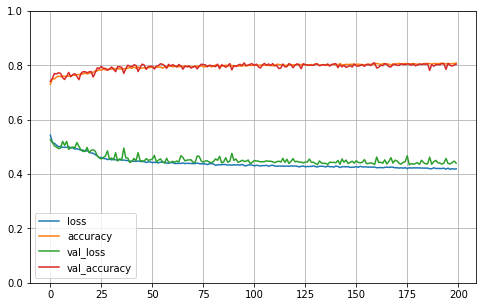

accuracy: 80.94%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 10s 22ms/step - loss: 0.5522 - accuracy: 0.7175 - val_loss: 0.5115 - val_accuracy: 0.7449
Epoch 2/200
453/453 [==============================] - 2s 5ms/step - loss: 0.5217 - accuracy: 0.7459 - val_loss: 0.4963 - val_accuracy: 0.7629
Epoch 3/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5097 - accuracy: 0.7559 - val_loss: 0.5050 - val_accuracy: 0.7517
Epoch 4/200
453/453 [==============================] - 2s 5ms/step - loss: 0.5044 - accuracy: 0.7600 - val_loss: 0.4913 - val_accuracy: 0.7753
Epoch 5/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5025 - accuracy: 0.7596 - val_loss: 0.5083 - val_accuracy: 0.7523
Epoch 6/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5025 - accuracy: 0.7593 - val_loss: 0.5022 - val_accuracy: 0.7592
Epoch 7/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4994 - accuracy: 0.

Epoch 102/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4370 - accuracy: 0.7980 - val_loss: 0.4409 - val_accuracy: 0.8032
Epoch 103/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4339 - accuracy: 0.8009 - val_loss: 0.4496 - val_accuracy: 0.8026
Epoch 104/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4357 - accuracy: 0.7976 - val_loss: 0.4720 - val_accuracy: 0.7834
Epoch 105/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4328 - accuracy: 0.7998 - val_loss: 0.4486 - val_accuracy: 0.7927
Epoch 106/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4354 - accuracy: 0.7987 - val_loss: 0.4438 - val_accuracy: 0.7952
Epoch 107/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4342 - accuracy: 0.7976 - val_loss: 0.4405 - val_accuracy: 0.8007
Epoch 108/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4325 - accuracy: 0.7994 - val_loss: 0.4410 - val_ac

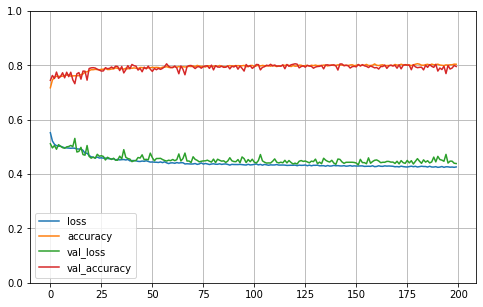

accuracy: 80.57%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 3s 6ms/step - loss: 0.5430 - accuracy: 0.7254 - val_loss: 0.5120 - val_accuracy: 0.7505
Epoch 2/200
453/453 [==============================] - 2s 5ms/step - loss: 0.5152 - accuracy: 0.7528 - val_loss: 0.5076 - val_accuracy: 0.7523
Epoch 3/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5090 - accuracy: 0.7567 - val_loss: 0.5049 - val_accuracy: 0.7492
Epoch 4/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5020 - accuracy: 0.7646 - val_loss: 0.4974 - val_accuracy: 0.7623
Epoch 5/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5008 - accuracy: 0.7643 - val_loss: 0.5067 - val_accuracy: 0.7492
Epoch 6/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5010 - accuracy: 0.7611 - val_loss: 0.5077 - val_accuracy: 0.7517
Epoch 7/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4990 - accuracy: 0.76

453/453 [==============================] - 1s 2ms/step - loss: 0.4355 - accuracy: 0.8021 - val_loss: 0.4472 - val_accuracy: 0.7908
Epoch 102/200
453/453 [==============================] - 2s 5ms/step - loss: 0.4321 - accuracy: 0.7998 - val_loss: 0.4423 - val_accuracy: 0.7933
Epoch 103/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4343 - accuracy: 0.7981 - val_loss: 0.4545 - val_accuracy: 0.7840
Epoch 104/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4329 - accuracy: 0.8000 - val_loss: 0.4465 - val_accuracy: 0.7896
Epoch 105/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4329 - accuracy: 0.8034 - val_loss: 0.4540 - val_accuracy: 0.7871
Epoch 106/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4315 - accuracy: 0.8020 - val_loss: 0.4484 - val_accuracy: 0.7871
Epoch 107/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4311 - accuracy: 0.8000 - val_loss: 0.4460 - val_accuracy: 0.7877

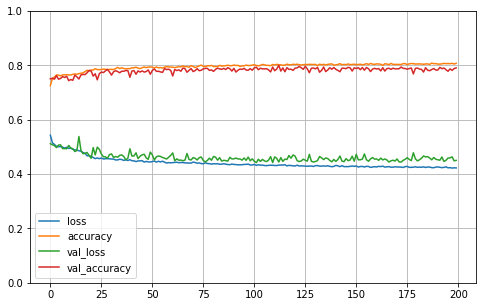

accuracy: 80.01%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 3s 6ms/step - loss: 0.5406 - accuracy: 0.7289 - val_loss: 0.4966 - val_accuracy: 0.7672
Epoch 2/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5134 - accuracy: 0.7518 - val_loss: 0.4961 - val_accuracy: 0.7697
Epoch 3/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5088 - accuracy: 0.7582 - val_loss: 0.4803 - val_accuracy: 0.7747
Epoch 4/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5042 - accuracy: 0.7586 - val_loss: 0.4779 - val_accuracy: 0.7741
Epoch 5/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5020 - accuracy: 0.7629 - val_loss: 0.4889 - val_accuracy: 0.7772
Epoch 6/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5003 - accuracy: 0.7592 - val_loss: 0.4791 - val_accuracy: 0.7716
Epoch 7/200
453/453 [==============================] - 2s 4ms/step - loss: 0.4982 - accuracy: 0.76

Epoch 42/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4483 - accuracy: 0.7919 - val_loss: 0.4466 - val_accuracy: 0.7970
Epoch 43/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4470 - accuracy: 0.7910 - val_loss: 0.4389 - val_accuracy: 0.8014
Epoch 44/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4492 - accuracy: 0.7913 - val_loss: 0.4538 - val_accuracy: 0.7939
Epoch 45/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4486 - accuracy: 0.7915 - val_loss: 0.4420 - val_accuracy: 0.7983
Epoch 46/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4487 - accuracy: 0.7933 - val_loss: 0.4329 - val_accuracy: 0.8070
Epoch 47/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4471 - accuracy: 0.7922 - val_loss: 0.4424 - val_accuracy: 0.8070
Epoch 48/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4467 - accuracy: 0.7934 - val_loss: 0.4508 - val_accuracy:

Epoch 94/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4357 - accuracy: 0.8012 - val_loss: 0.4400 - val_accuracy: 0.8026
Epoch 95/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4368 - accuracy: 0.7969 - val_loss: 0.4257 - val_accuracy: 0.8175
Epoch 96/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4370 - accuracy: 0.7966 - val_loss: 0.4298 - val_accuracy: 0.8107
Epoch 97/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4366 - accuracy: 0.7971 - val_loss: 0.4421 - val_accuracy: 0.8001
Epoch 98/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4365 - accuracy: 0.7977 - val_loss: 0.4290 - val_accuracy: 0.8051
Epoch 99/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4352 - accuracy: 0.8008 - val_loss: 0.4246 - val_accuracy: 0.8132
Epoch 100/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4353 - accuracy: 0.7969 - val_loss: 0.4313 - val_accuracy

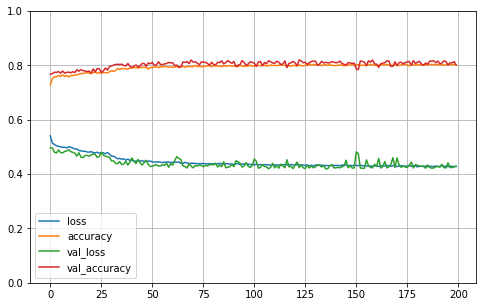

accuracy: 82.00%

5-way Cross Validation mean 80.83% (+/- 0.66%)
Done


In [10]:
print ("Cross valiation")
do_cross_validation(X_train,y_train,model)  
print ("Done")